## 금주 목표
### 이번 시즌 팀 순위 시각화

In [3]:
import natsort as natsort
import pandas as pd
import os
import natsort
#from IPython.core.display_functions import display


In [2]:
for month in range(4, 10):
    url = "https://sports.news.naver.com/kbaseball/schedule/index?&month={}&year=2022&teamCode=".format(month)
    df = pd.read_html(url)
    for i in range(1, len(df)-1): #제일 위에 column 목차가 df단위로 떨어져서 삭제하는걸로 함, 그리고 마지막 df는 <맨위로>키 정보가 있는 테이블이라 범위에 넣지 않음.
        if df[i][2][0] == "프로야구 경기가 없습니다.":
            continue
        remain= df[i].loc[:, [0, 1, 2, 4, 5]]
        remain.rename(columns={0:"일자", 1:"시각", 2:"경기결과", 4:"중계사", 5:"구장"} , inplace=True)
        text = remain["일자"][0].split()[0]
        remain["일자"] = text
        remain.to_csv("./date/"+text+'.csv', header=True, encoding='UTF-8', index=False)
    print(month, "완료")

4 완료
5 완료
6 완료
7 완료
8 완료
9 완료


## DataFrame 에서 얻어낸 것
1. 네이버는 https 프로토콜을 사용하므로 ssl때문에 certification 관련 추가 작업이 필요했음
1-1. 따라서 terminal에 `pip install --upgrade certifi`를 추가적으로 작성함
1-2. 그리고 Application > python 3.10 > install certifi 진행
2. 네이버의 경우, 일정별로 깔끔하게 떨어져서 나옴
3. 다만, 데이터프레임의 개수가 많이 나타남

## 게임차 계산방법
```
팀 게임 승점 = (전체경기수 - 진행된 경기수)*0.5 + 승리 수 + 무승부*0.5
1위 승점 - 현재 팀 승점
```
- 패배를 왜 뺐나 했는데, 정말로 게임차 계산할 때 패배는 들어가지 않음.
- 실제로도 승리랑 무승부 가지고 판단함

In [4]:
start_data = {"LG":[0,0,0,0],
              "KIA":[0,0,0,0],
              "NC":[0,0,0,0],
              "SSG":[0,0,0,0],
              "한화":[0,0,0,0],
              "두산":[0,0,0,0],
              "키움":[0,0,0,0],
              "삼성":[0,0,0,0],
              "KT":[0,0,0,0],
              "롯데":[0,0,0,0]}
KBO_team = pd.DataFrame(start_data, index= ["경기수", "승리", "무승부","패배"])
KBO_team = KBO_team.T
KBO_team

,경기수,승리,무승부,패배
LG,0,0,0,0
KIA,0,0,0,0
NC,0,0,0,0
SSG,0,0,0,0
한화,0,0,0,0
두산,0,0,0,0
키움,0,0,0,0
삼성,0,0,0,0
KT,0,0,0,0
롯데,0,0,0,0


In [5]:
order_list = os.listdir("./date")
sorted_list = natsort.natsorted(order_list)
sorted_list

['4.2.csv',
 '4.3.csv',
 '4.5.csv',
 '4.6.csv',
 '4.7.csv',
 '4.8.csv',
 '4.9.csv',
 '4.10.csv',
 '4.12.csv',
 '4.13.csv',
 '4.14.csv',
 '4.15.csv',
 '4.16.csv',
 '4.17.csv',
 '4.19.csv',
 '4.20.csv',
 '4.21.csv',
 '4.22.csv',
 '4.23.csv',
 '4.24.csv',
 '4.26.csv',
 '4.27.csv',
 '4.28.csv',
 '4.29.csv',
 '4.30.csv',
 '5.1.csv',
 '5.3.csv',
 '5.4.csv',
 '5.5.csv',
 '5.6.csv',
 '5.7.csv',
 '5.8.csv',
 '5.10.csv',
 '5.11.csv',
 '5.12.csv',
 '5.13.csv',
 '5.14.csv',
 '5.15.csv',
 '5.17.csv',
 '5.18.csv',
 '5.19.csv',
 '5.20.csv',
 '5.21.csv',
 '5.22.csv',
 '5.24.csv',
 '5.25.csv',
 '5.26.csv',
 '5.27.csv',
 '5.28.csv',
 '5.29.csv',
 '5.31.csv',
 '6.1.csv',
 '6.2.csv',
 '6.3.csv',
 '6.4.csv',
 '6.5.csv',
 '6.7.csv',
 '6.8.csv',
 '6.9.csv',
 '6.10.csv',
 '6.11.csv',
 '6.12.csv',
 '6.14.csv',
 '6.15.csv',
 '6.16.csv',
 '6.17.csv',
 '6.18.csv',
 '6.19.csv',
 '6.21.csv',
 '6.22.csv',
 '6.23.csv',
 '6.24.csv',
 '6.25.csv',
 '6.26.csv',
 '6.28.csv',
 '6.29.csv',
 '6.30.csv',
 '7.1.csv',
 '7.2.csv

In [6]:
for file in sorted_list:
    data = pd.read_csv("./date/" + file)
    for i in data.index:
        line = data.loc[i, :]

        if len(line[2].split(":")) == 1:
            continue

        away, home = line[2].split(":")
        home = home.split()
        away = away.split()
        h_score, h_team = home
        a_team, a_score = away
        h_score = int(h_score)
        a_score = int(a_score)

        if h_team == "나눔" or a_team == "나눔":
            continue #올스타전 제외

        #리팩토링은 항상 모두 완료하고나서 할 것
        if h_score > a_score: #홈팀 승리
            KBO_team.loc[h_team, ["승리"]] +=1
            KBO_team.loc[a_team, ["패배"]] +=1
        elif h_score < a_score:
            KBO_team.loc[a_team, ["승리"]] +=1
            KBO_team.loc[h_team, ["패배"]] +=1
        else:
            KBO_team.loc[h_team, ["무승부"]] +=1
            KBO_team.loc[a_team, ["무승부"]] +=1

        #경기수 구하기
        KBO_team["경기수"] = KBO_team["승리"] + KBO_team["패배"] + KBO_team["무승부"]

        #게임차 구하기
        KBO_team["승점"] = (144-KBO_team["경기수"])*0.5 + KBO_team["승리"] + KBO_team["무승부"]*0.5
        KBO_team.sort_values(by="승점", inplace=True, ascending=False)
        top = KBO_team["승점"][0]
        KBO_team["게임차"] = top - KBO_team["승점"]
        KBO_team.sort_values(by="승점", ascending=False, inplace=True)

        KBO_team["순위"] = [1,2,3,4,5,6,7,8,9,10]

        KBO_team.to_csv("./date_rank/"+file, header=True, encoding="UTF-8", index=True)
#원인찾았다. 이거 숫자가 문자열로 되어있어서 그랬음

In [7]:
KBO_team

,경기수,승리,무승부,패배,승점,게임차,순위
SSG,137,86,4,47,91.5,0.0,1
LG,133,82,2,49,88.5,3.0,2
키움,140,78,2,60,81.0,10.5,3
KT,136,75,2,59,80.0,11.5,4
KIA,136,65,1,70,69.5,22.0,5
NC,134,61,3,70,67.5,24.0,6
롯데,138,61,4,73,66.0,25.5,7
삼성,135,60,2,73,65.5,26.0,8
두산,134,56,2,76,62.0,29.5,9
한화,137,44,2,91,48.5,43.0,10


## 시각화 진행할 것

In [8]:
rank_list = os.listdir("./date_rank")
sorted_rank = natsort.natsorted(order_list)
sorted_rank

['4.2.csv',
 '4.3.csv',
 '4.5.csv',
 '4.6.csv',
 '4.7.csv',
 '4.8.csv',
 '4.9.csv',
 '4.10.csv',
 '4.12.csv',
 '4.13.csv',
 '4.14.csv',
 '4.15.csv',
 '4.16.csv',
 '4.17.csv',
 '4.19.csv',
 '4.20.csv',
 '4.21.csv',
 '4.22.csv',
 '4.23.csv',
 '4.24.csv',
 '4.26.csv',
 '4.27.csv',
 '4.28.csv',
 '4.29.csv',
 '4.30.csv',
 '5.1.csv',
 '5.3.csv',
 '5.4.csv',
 '5.5.csv',
 '5.6.csv',
 '5.7.csv',
 '5.8.csv',
 '5.10.csv',
 '5.11.csv',
 '5.12.csv',
 '5.13.csv',
 '5.14.csv',
 '5.15.csv',
 '5.17.csv',
 '5.18.csv',
 '5.19.csv',
 '5.20.csv',
 '5.21.csv',
 '5.22.csv',
 '5.24.csv',
 '5.25.csv',
 '5.26.csv',
 '5.27.csv',
 '5.28.csv',
 '5.29.csv',
 '5.31.csv',
 '6.1.csv',
 '6.2.csv',
 '6.3.csv',
 '6.4.csv',
 '6.5.csv',
 '6.7.csv',
 '6.8.csv',
 '6.9.csv',
 '6.10.csv',
 '6.11.csv',
 '6.12.csv',
 '6.14.csv',
 '6.15.csv',
 '6.16.csv',
 '6.17.csv',
 '6.18.csv',
 '6.19.csv',
 '6.21.csv',
 '6.22.csv',
 '6.23.csv',
 '6.24.csv',
 '6.25.csv',
 '6.26.csv',
 '6.28.csv',
 '6.29.csv',
 '6.30.csv',
 '7.1.csv',
 '7.2.csv

In [9]:
for file in sorted_rank[:5]:
    test_df = pd.read_csv("./date_rank/"+file)
    display(test_df)

,Unnamed: 0,경기수,승리,무승부,패배,승점,게임차,순위
0,두산,1,1,0,0,72.5,0.0,1
1,LG,1,1,0,0,72.5,0.0,2
2,롯데,1,1,0,0,72.5,0.0,3
3,SSG,1,1,0,0,72.5,0.0,4
4,KT,1,1,0,0,72.5,0.0,5
5,삼성,1,0,0,1,71.5,1.0,6
6,NC,1,0,0,1,71.5,1.0,7
7,키움,1,0,0,1,71.5,1.0,8
8,KIA,1,0,0,1,71.5,1.0,9
9,한화,1,0,0,1,71.5,1.0,10


,Unnamed: 0,경기수,승리,무승부,패배,승점,게임차,순위
0,두산,2,2,0,0,73.0,0.0,1
1,LG,2,2,0,0,73.0,0.0,2
2,SSG,2,2,0,0,73.0,0.0,3
3,KT,2,1,0,1,72.0,1.0,4
4,롯데,2,1,0,1,72.0,1.0,5
5,키움,2,1,0,1,72.0,1.0,6
6,삼성,2,1,0,1,72.0,1.0,7
7,NC,2,0,0,2,71.0,2.0,8
8,KIA,2,0,0,2,71.0,2.0,9
9,한화,2,0,0,2,71.0,2.0,10


,Unnamed: 0,경기수,승리,무승부,패배,승점,게임차,순위
0,LG,3,3,0,0,73.5,0.0,1
1,SSG,3,3,0,0,73.5,0.0,2
2,두산,3,2,0,1,72.5,1.0,3
3,롯데,3,2,0,1,72.5,1.0,4
4,삼성,3,2,0,1,72.5,1.0,5
5,KT,3,1,0,2,71.5,2.0,6
6,키움,3,1,0,2,71.5,2.0,7
7,KIA,3,1,0,2,71.5,2.0,8
8,NC,3,0,0,3,70.5,3.0,9
9,한화,3,0,0,3,70.5,3.0,10


,Unnamed: 0,경기수,승리,무승부,패배,승점,게임차,순위
0,LG,4,4,0,0,74.0,0.0,1
1,SSG,4,4,0,0,74.0,0.0,2
2,삼성,4,3,0,1,73.0,1.0,3
3,두산,4,2,0,2,72.0,2.0,4
4,롯데,4,2,0,2,72.0,2.0,5
5,KIA,4,2,0,2,72.0,2.0,6
6,KT,4,1,0,3,71.0,3.0,7
7,키움,4,1,0,3,71.0,3.0,8
8,NC,4,1,0,3,71.0,3.0,9
9,한화,4,0,0,4,70.0,4.0,10


,Unnamed: 0,경기수,승리,무승부,패배,승점,게임차,순위
0,LG,5,5,0,0,74.5,0.0,1
1,SSG,5,5,0,0,74.5,0.0,2
2,삼성,5,3,0,2,72.5,2.0,3
3,KIA,5,3,0,2,72.5,2.0,4
4,롯데,5,3,0,2,72.5,2.0,5
5,두산,5,3,0,2,72.5,2.0,6
6,KT,5,1,0,4,70.5,4.0,7
7,NC,5,1,0,4,70.5,4.0,8
8,키움,5,1,0,4,70.5,4.0,9
9,한화,5,0,0,5,69.5,5.0,10


In [39]:
test_data = pd.read_csv("./date_rank/8.4.csv", index_col=False)
test_data.rename(columns={"Unnamed: 0":"팀명"}, inplace=True)
test_data

,팀명,경기수,승리,무승부,패배,승점,게임차,순위
0,SSG,97,65,3,29,90.0,0.0,1
1,키움,98,58,2,38,82.0,8.0,2
2,LG,95,57,1,37,82.0,8.0,3
3,KT,94,50,2,42,76.0,14.0,4
4,KIA,95,48,1,46,73.0,17.0,5
5,두산,93,41,2,50,67.5,22.5,6
6,롯데,97,40,4,53,65.5,24.5,7
7,NC,93,38,3,52,65.0,25.0,8
8,삼성,96,39,2,55,64.0,26.0,9
9,한화,96,30,2,64,55.0,35.0,10


### 정리
- 현재 필요한 정보: 순위 별 팀명, 일자

In [40]:
test_data = pd.DataFrame(test_data[["팀명", "순위"]])
test_data = test_data.T

In [41]:
num_list = [int(i) for i in range(1,11)]
num_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [42]:
test_data.columns = num_list
file = file.replace('.csv','')
test_data.loc["일자"] = file

In [43]:
test_data

,1,2,3,4,5,6,7,8,9,10
팀명,SSG,키움,LG,KT,KIA,두산,롯데,NC,삼성,한화
순위,1,2,3,4,5,6,7,8,9,10
일자,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7,4.7


In [74]:
result_df = pd.DataFrame(test_data.loc[["일자", "팀명", "순위"]])
result_df = result_df.T

In [77]:
result_df.index = result_df["팀명"]

In [78]:
result_df

,일자,팀명,순위
팀명,,,
SSG,4.7,SSG,1
키움,4.7,키움,2
LG,4.7,LG,3
KT,4.7,KT,4
KIA,4.7,KIA,5
두산,4.7,두산,6
롯데,4.7,롯데,7
NC,4.7,NC,8
삼성,4.7,삼성,9


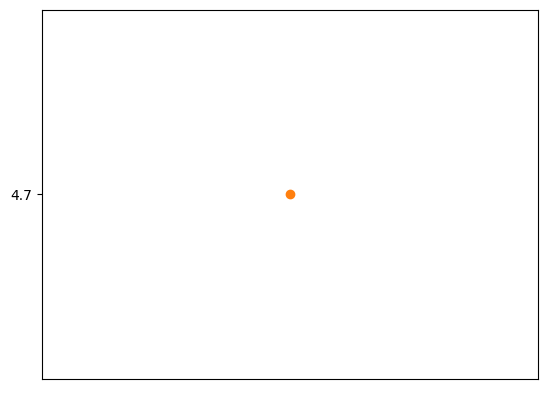

In [84]:
from matplotlib import pyplot as plt
LG_y = result_df.loc["LG", "순위"]
LG_x = result_df.loc["LG", "일자"]
NC_x = result_df.loc["NC", "순위"]
NC_y = result_df.loc["NC", "일자"]
plt.scatter(LG_x, LG_y)
plt.scatter(NC_x, NC_y)